In [3]:
# importing required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.utils.vis_utils import plot_model
from IPython import display
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.txt",header=None)
index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/index.txt",header=None)
data = data.to_numpy()
index = index.to_numpy()

In [6]:
print(data.shape)
print(index.shape)
train_dataset = np.reshape(data,(-1,720,16,1))
print(train_dataset.shape)

(2246400, 16)
(6240, 2)
(3120, 720, 16, 1)


In [7]:
print(train_dataset[2].shape)
train_imgs = train_dataset

(720, 16, 1)


In [8]:
N_Imag = 3120
Batch_Size = 12
noise_d = 200
train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(N_Imag).batch(Batch_Size)

In [9]:
def add_noise(imag):
  image = np.squeeze(imag)
  C = image.shape[1]
  R = image.shape[0]
  Rand = np.random.randint(0,C, size=1)
  Rand_Cov = np.random.uniform(1,10)
  Rand_Mean = np.random.normal(0,3)
  N = np.random.normal(Rand_Mean,Rand_Cov,size=(R,1))
  Noise = np.zeros(image.shape)
  Noise[:,Rand] = Noise[:,Rand] + N
  image = image + Noise
  image = image.reshape(R,C,1)
  return image

def channel_drop(imag):
  image = np.squeeze(imag)
  C = image.shape[1]
  R = image.shape[0]
  Rand = np.random.randint(0,C, size=1)
  image[:,Rand] = np.zeros(image[:,Rand].shape)
  image = image.reshape(R,C,1)
  return image

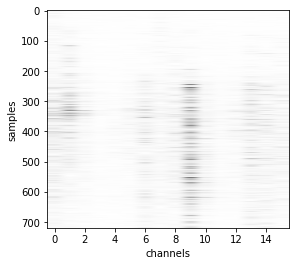

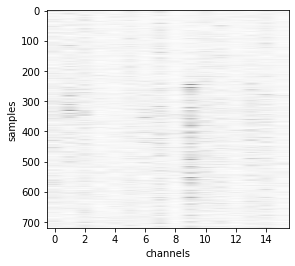

In [10]:
noised = add_noise(train_imgs[10])
dropped = channel_drop(train_imgs[3])
for i in range(100):
  noised = add_noise(noised)


img = train_imgs[10]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(img[:,:,0]),cmap='Greys')
plt.xlabel('channels')
plt.ylabel('samples')
ax.set_aspect(0.02)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(noised[:,:,0]),cmap='Greys')
plt.xlabel('channels')
plt.ylabel('samples')
ax.set_aspect(0.02)

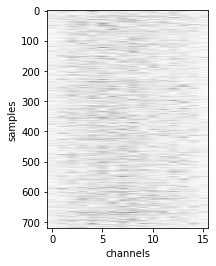

In [12]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16*720*1, use_bias=False, input_shape=(16*720,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((720, 16, 1)))
    model.add(layers.UpSampling2D(size=2))
    assert model.output_shape == (None, 1440, 32, 1) 

    model.add(layers.Conv2D(64, (2,10), strides=(1,1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 1440, 32, 64)
    # Second Layer (1st Deconvolution)
    model.add(layers.Conv2DTranspose(128, (2,10), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 1440, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Thirds Layer (2nd Deconvolution)
    model.add(layers.Conv2D(64, (2,10), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 720, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(32, (2,10), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 720, 16, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 720, 16, 1)

    # Forth Layer (3rd Deconvolution)
    #model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 16, 720, 1)

    return model

G = generator_model()
# Making Noise !!
noise = tf.random.normal([1, 16*720])
# Feeding the noise to the generator
generated_img = G(noise, training=False)
# Plotting the (not-so-fancy) output 
#plt.imshow(generated_img[0,:,:,0], cmap='gray')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(generated_img[0,:,:,0]),cmap='Greys')
plt.xlabel('channels')
plt.ylabel('samples')
ax.set_aspect(0.03)

In [13]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11520)             132710400 
_________________________________________________________________
batch_normalization (BatchNo (None, 11520)             46080     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 11520)             0         
_________________________________________________________________
reshape (Reshape)            (None, 720, 16, 1)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 1440, 32, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1440, 32, 64)      1344      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1440, 32, 64)      0

In [14]:
def discriminator_model():
    model = tf.keras.Sequential()
    # First 2D Conv Layer
    model.add(layers.Conv2D(64, (2,10), strides=(2,2), padding='same', input_shape=[720,16,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Second 2D Conv Layer
    model.add(layers.Conv2D(128,(2,10), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Flatten the output of the second layer
    model.add(layers.Flatten())
    # Dense layer for scalar output
    model.add(layers.Dense(1))

    return model

D = discriminator_model()

In [15]:
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 360, 8, 64)        1344      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 360, 8, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 360, 8, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 4, 128)       163968    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 180, 4, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 4, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 92160)            

In [16]:
# Defining Binary-Cross-Entropy loss function instance 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Discriminator Loss Function
def discriminator_loss(true_output, fake_output):
    T = cross_entropy(tf.ones_like(true_output), true_output)
    F = cross_entropy(tf.zeros_like(fake_output), fake_output)
    D_loss = F + T
    return D_loss
# Generator Loss Function
def generator_loss(fake_output):
    F = cross_entropy(tf.ones_like(fake_output), fake_output)
    return F

In [17]:
G_Opt = tf.keras.optimizers.Adam(1e-3)
D_Opt = tf.keras.optimizers.Adam(1e-3)
Epochs = 500

In [18]:
def input_for_GAN(batch_size, Train_Images, n_Image):
  N = np.random.randint(0,n_Image,batch_size)
  Images = []
  for i in N:
    image = Train_Images[i,:,:,:]
    image = channel_drop(image)
    image = add_noise(image)
    image = np.reshape(image,(16*720,1),'F')
    Images.append(image)

  return Images

In [19]:
A = tf.convert_to_tensor(tf.squeeze(input_for_GAN(Batch_Size, train_imgs, N_Imag)))
print(A.shape)

(12, 11520)


In [20]:
@tf.function
def train_step(images):
    # noise = tf.random.normal([Batch_Size, noise_d])
    image_input = np.array(input_for_GAN(Batch_Size, train_imgs, N_Imag))
    image_input = tf.convert_to_tensor(image_input)
    image_input = tf.reshape(image_input,([Batch_Size, 11520]))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Making a Noise generated image through the Generator
        generated_img = G(image_input, training=True) 
        # True and Fake outputs from Discriminator
        T_out = D(images, training=True)
        F_out = D(generated_img, training=True)
        # Generator Loss
        G_Loss = generator_loss(F_out)
        # Discriminator Loss
        D_Loss = discriminator_loss(T_out, F_out)
    # Gradient Computation
    grad_gen = gen_tape.gradient(G_Loss, G.trainable_variables)
    grad_disc = disc_tape.gradient(D_Loss, D.trainable_variables)
    # Updating the weights
    G_Opt.apply_gradients(zip(grad_gen, G.trainable_variables))
    D_Opt.apply_gradients(zip(grad_disc, D.trainable_variables))
    # Returning the Losses
    return tf.cast(G_Loss, tf.float32),tf.cast(D_Loss, tf.float32)

In [21]:
def train(dataset, epochs):

    G_Loss_History = []
    D_Loss_History = []
    for epoch in range(epochs):
        
        start = time.time()
        G_Losses = []
        D_Losses = []
        for img_batch in dataset:
            G_Loss, D_Loss = train_step(img_batch)
            # Saving the Loss values in an array for the entire dataset
            G_Losses.append(G_Loss)
            D_Losses.append(D_Loss)
            
        # History of all Loss Function Arrays
        G_Loss_History.append(G_Losses)
        D_Loss_History.append(D_Losses)
        G_Mean = sum(G_Losses)/len(G_Losses)
        D_Mean = sum(D_Losses)/len(D_Losses)
        print("Finished training epoch: ", epoch + 1)
        print("Generator Loss : ", G_Mean.numpy() , "Discriminator Loss : ", D_Mean.numpy())


    # Returning Errors
    return G_Loss_History, D_Loss_History

In [ ]:
G_Loss_History, D_Loss_History = train(train_set, Epochs)

In [ ]:

G_Loss = []
D_Loss = []
for i in range(Epochs):
  G_Loss_i = G_Loss_History[i]
  Mean = sum(G_Loss_i)/len(G_Loss_i)
  G_Loss.append(Mean.numpy())
  D_Loss_i = D_Loss_History[i]
  Mean = sum(D_Loss_i)/len(D_Loss_i)
  D_Loss.append(Mean.numpy())

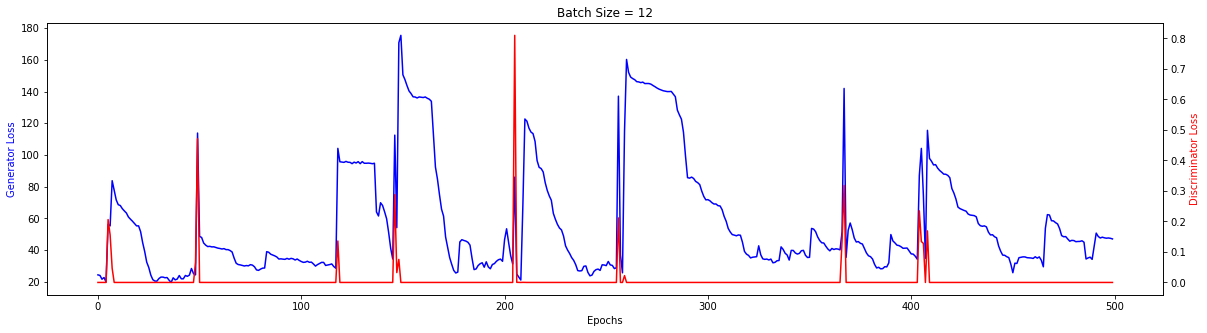

In [ ]:


fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(G_Loss, 'b-')
ax1.set_ylabel('Generator Loss', color='b')
ax1.set_xlabel('Epochs',color='k')
ax2 = ax1.twinx()
ax2.plot(D_Loss, 'r-')
ax2.set_ylabel('Discriminator Loss', color='r')
plt.title('Batch Size = 12')
plt.show()

In [ ]:
image_input = input_for_GAN(Batch_Size)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(torch.squeeze(np.abs(generator(latent_1).detach().cpu())),cmap='Greys')
plt.xlabel('channels')
plt.ylabel('samples')
ax.set_aspect(0.01)

out = torch.squeeze(generator(latent_1).detach().cpu())
fig = plt.figure()
plt.plot(out[:,0])

In [ ]:
seed = input_for_GAN(Batch_Size, noise_d, train_imgs, N_Imag)
seed = tf.convert_to_tensor(seed)

In [ ]:
predictions = G(seed, training=False)
predictions = predictions.numpy()
predictions = np.reshape(predictions,(16,720))
print(predictions.shape)

In [ ]:
df = pd.DataFrame(data=predictions)
df.to_csv("./GAN2_out.csv", sep=',',index=False)